<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/UO288756.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
import tensorflow.keras.backend as K


# Se monta el Google Drive en el directorio del proyecto y se descomprime posteriormente.
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
data_path = '/content/'
imgtrain_dir = data_path + "train/images/"
csvtrain_file = data_path + "train.csv"

imgtest_dir = data_path + "test/images/"
csvtest_file = data_path + "test.csv"

df = pd.read_csv(csvtrain_file, dtype = {"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype = {"class": "category"})
# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Convertir las etiquetas codificadas en un vector one-hot
class_one_hot = pd.get_dummies(df['class_encoded'], prefix='class')

# Renombrar las columnas del vector one-hot
class_one_hot.columns = ['normal', 'benign', 'malignant']

# Concatenar el DataFrame original con las etiquetas one-hot
df = pd.concat([df[['image_filename']], class_one_hot], axis=1)

# Convertir los valores booleanos en enteros (0 y 1)
df['normal'] = df['normal'].astype(int)
df['benign'] = df['benign'].astype(int)
df['malignant'] = df['malignant'].astype(int)

print(df.head())

  image_filename  normal  benign  malignant
0  image_003.png       1       0          0
1  image_004.png       1       0          0
2  image_008.png       1       0          0
3  image_012.png       1       0          0
4  image_016.png       1       0          0


Se separa el DataFrame en 3: para entrenar, para hacer validación y para test. Las proporciones serán de 80:10:10, ya que así se da prioridad a tener más elementos para poder realizar el entrenamiento.

In [80]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.1)
test_size = int(len(df) * 0.1)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 271
Número de ejemplos del conjunto de validación: 33
Número de ejemplos del conjunto de test: 33


In [85]:
dftrain

,image_filename,normal,benign,malignant
0,image_116.png,1,0,0
1,image_396.png,1,0,0
2,image_267.png,0,0,1
3,image_044.png,1,0,0
4,image_158.png,1,0,0
...,...,...,...,...
266,image_115.png,0,1,0
267,image_209.png,1,0,0
268,image_371.png,1,0,0
269,image_109.png,0,0,1


In [93]:
print(dfval.head())
print(dfval.tail())

  image_filename  normal  benign  malignant
0  image_197.png       1       0          0
1  image_074.png       0       1          0
2  image_076.png       0       1          0
3  image_357.png       0       0          1
4  image_292.png       0       1          0
   image_filename  normal  benign  malignant
28  image_151.png       0       1          0
29  image_297.png       1       0          0
30  image_274.png       0       0          1
31  image_093.png       1       0          0
32  image_346.png       0       1          0


In [94]:
# Calcular el número de muestras para cada clase
num_normal = dftrain.loc[dftrain['normal'] == True].shape[0]
num_benign = dftrain.loc[dftrain['benign'] == True].shape[0]
num_malignant = dftrain.loc[dftrain['malignant'] == True].shape[0]

print("Número de muestras para la clase 'normal':", num_normal)
print("Número de muestras para la clase 'benign':", num_benign)
print("Número de muestras para la clase 'malignant':", num_malignant)


Número de muestras para la clase 'normal': 133
Número de muestras para la clase 'benign': 97
Número de muestras para la clase 'malignant': 41


In [82]:
import tensorflow as tf
from tensorflow.data import Dataset

# Dimensiones deseadas de la imagen
img_width, img_height = 448,448
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases
x_col = 'image_filename'      # nombres de las columnas en el fichero CSV
y_col = ['normal', 'benign', 'malignant']  # lista de nombres de las columnas de las etiquetas

# Cargar y preprocesar imágenes
def load_and_preprocess_image(image_filename, label_one_hot):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize_with_pad(image, img_width, img_height)
    image = image / 255.0
    label = label_one_hot
    return image, label

# Crear conjunto de datos
def get_dataset(df):
    image_filenames = df[x_col].values
    labels = df[y_col].values
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, labels))
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)
print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')

Número de lotes del conjunto de entrenamiento: 9
Número de lotes del conjunto de validación: 2
Número de lotes del conjunto de test: 2


El tamaño de batch es 32 ya que este tamaño de lote es lo suficientemente grande como para aprovechar la eficiencia de las operaciones en paralelo pero no lo suficiente para tener problemas de recursos. Aparte, también ayuda a la generalización. Las imágenes son de 448x448 porque si son más pequeñas puede que el modelo no capte el objeto que nos interesa dentro de ellas.

A continuación, se imprimen unos ejemplos para comprobar que los datos se han cargado correctamente:

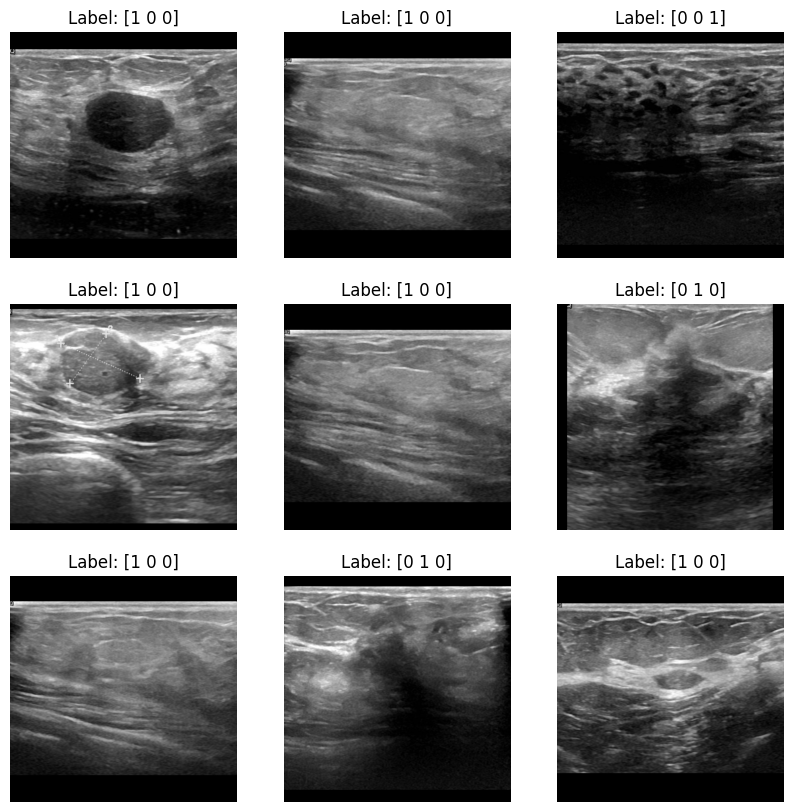

In [95]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes del conjunto de datos de entrenamiento
for images, labels in train_dataset.take(1):
    # Visualizar las primeras 9 imágenes del lote
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')


In [100]:
def f1(y_true, y_pred):
    # Convertir las predicciones y verdaderos valores a tensores de TensorFlow
    y_pred_labels = K.round(y_pred)
    y_true_labels = K.round(y_true)

    # Calcular los valores verdaderos positivos, falsos positivos y falsos negativos para cada clase
    true_positives = K.sum(K.cast(y_true_labels * y_pred_labels, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_labels, 'float'), axis=0)
    possible_positives = K.sum(K.cast(y_true_labels, 'float'), axis=0)

    # Calcular la precisión y el recall para cada clase
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calcular la métrica F1 para cada clase
    f1_per_class = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calcular el peso de cada clase (número de ejemplos)
    num_examples_per_class = K.sum(y_true_labels, axis=0)
    class_weights = num_examples_per_class / K.sum(num_examples_per_class)

    # Calcular la métrica F1 promedio ponderada
    weighted_f1 = K.sum(class_weights * f1_per_class)

    return weighted_f1


def get_model(input_shape, num_classes):
    # Definir el modelo InceptionV3 pre-entrenado
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar las capas de la base del modelo
    base_model.trainable = False

    # Agregar capas adicionales de clasificación
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Capa de pooling global para reducir la dimensionalidad
    x = layers.Dense(1024, activation='relu')(x)  # Capa densa con activación ReLU
    predictions = layers.Dense(num_classes, activation='softmax')(x)  # Capa de salida con activación softmax

    # Combinar el modelo base con las capas adicionales
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Ejemplo de uso:
input_shape = (img_width, img_height, 3)  # Tamaño de entrada de las imágenes
num_classes = 3  # Número de clases en ImageNet
model = get_model(input_shape, num_classes)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

# Resumen del modelo
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv2d_1416 (Conv2D)        (None, 223, 223, 32)         864       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_1410 (  (None, 223, 223, 32)         96        ['conv2d_1416[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1410 (Activatio  (None, 223, 223, 32)         0         ['batch_normalization_1

Se va a utilizar un modelo pre-entrenado Inception, este ha demostrado su eficacia en una amplia gama de conjuntos de datos de imágenes, incluidos conjuntos de datos médicos. Como métrica se va a usar el f1 implementado en el código, Adam será el optimizador y la crossentropy categórica la función de pérdida, ya que se trata de un problema de clasificación multiclase.

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='max')
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=25,
    callbacks=[early_stopping]
)

# Error mínimo de entrenamiento y validación
train_trace = np.array(history.history['loss'])
print(f'\nError mínimo en entrenamiento: {min(train_trace):.6f}')

val_trace = np.array(history.history['val_loss'])
print(f'Error mínimo en validación: {min(val_trace):.6f}')

# F1 mínimo de entrenamiento y validación
train_f1 = np.array(history.history['f1'])
print(f'\nF1 mínimo en entrenamiento: {min(train_f1):.6f}')

vali_f1 = np.array(history.history['val_f1'])
print(f'F1 mínimo en validación: {min(vali_f1):.6f}')

Epoch 1/25
9/9 [==============================] - 10s 517ms/step - loss: 1.8727 - f1: 0.2272 - val_loss: 1.2708 - val_f1: 0.6434
Epoch 2/25
9/9 [==============================] - 3s 291ms/step - loss: 1.0046 - f1: 0.3345 - val_loss: 0.8461 - val_f1: 0.7781
Epoch 3/25
9/9 [==============================] - 4s 441ms/step - loss: 0.8048 - f1: 0.5711 - val_loss: 0.7570 - val_f1: 0.8165
Epoch 4/25
9/9 [==============================] - 3s 327ms/step - loss: 0.7196 - f1: 0.6159 - val_loss: 0.6740 - val_f1: 0.8628
Epoch 5/25
9/9 [==============================] - 3s 327ms/step - loss: 0.6530 - f1: 0.6742 - val_loss: 0.6772 - val_f1: 0.8665
Epoch 6/25
9/9 [==============================] - 3s 293ms/step - loss: 0.6134 - f1: 0.6737 - val_loss: 0.6655 - val_f1: 0.8745
Epoch 7/25
9/9 [==============================] - 3s 318ms/step - loss: 0.5665 - f1: 0.7245 - val_loss: 0.6592 - val_f1: 0.8887
Epoch 8/25
9/9 [==============================] - 3s 317ms/step - loss: 0.5255 - f1: 0.7766 - val_loss:

Se ha usado el Early Stopping para evitar el sobreajuste, una vez terminado el entrenamiento se evalua con el conjunto de test que previamente se ha definido:

In [102]:
test_loss, test_f1 = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_f1: %.4f" % (test_loss, test_f1))

2/2 - 1s - loss: 0.3897 - f1: 0.9231 - 532ms/epoch - 266ms/step
test_loss: 0.3897, test_f1: 0.9231


Por último, se predice el conjunto de imágenes de test y se genera un csv con la predicción.

In [103]:
# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(imgtest_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(imgtest_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

predictions_df = predictions_df.sort_values(by='image_filename')
predictions_df.to_csv('test_predictions.csv', index=False)
print(predictions_df)

1/1 [==============================] - 0s 28ms/step
    image_filename  normal  benign  malignant
64   image_005.png       1       0          0
53   image_006.png       1       0          0
112  image_007.png       1       0          0
40   image_009.png       1       0          0
21   image_010.png       1       0          0
..             ...     ...     ...        ...
50   image_436.png       1       0          0
90   image_441.png       0       1          0
67   image_446.png       1       0          0
95   image_447.png       1       0          0
52   image_450.png       0       1          0

[113 rows x 4 columns]
